In [1]:
#import useful libraries for analysis and modeling
import pandas as pd
import numpy as np
from sklearn import tree
from scipy import stats
import os
import pickle
import sys
import tempfile
import math
# import matplotlib as mpl
# import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.tree import export_graphviz, DecisionTreeClassifier
pd.options.mode.chained_assignment = None
from IPython.display import display, HTML
import warnings
import json
from matplotlib import cm  # color map
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
import copy as cp
import shap
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, DistanceMetric
from sklearn.preprocessing import scale
from sklearn.datasets import load_iris, load_wine
from matplotlib import pyplot as plt
import colorcet as cc
from sklearn.covariance import EllipticEnvelope 
#
from sklearn.cluster import OPTICS
from sklearn.cluster import DBSCAN
from sklearn.cluster import HDBSCAN
from sklearn.cluster import AgglomerativeClustering
import gower
from scipy.spatial.distance import hamming

# Filter all warnings
warnings.filterwarnings("ignore")


In [10]:
# classes = ['Dropcam', 'HP Printer', 'Netatmo Welcome', 'Withings Smart Baby Monitor', 'Netatmo weather station',\
#            'Smart Things', 'Amazon Echo', 'Samsung SmartCam','TP-Link Day Night Cloud camera', 'Triby Speaker',\
#               'Belkin Wemo switch', 'TP-Link Smart plug', 'PIX-STAR Photo-frame','Belkin wemo motion sensor',\
#                      'Samsung Galaxy Tab', 'NEST Protect smoke alarm', 'Withings Smart scale', 'IPhone',\
#                             'MacBook', 'Withings Aura smart sleep sensor','Light Bulbs LiFX Smart Bulb',\
#                             'Blipcare Blood Pressure meter','iHome', 'Insteon Camera', 'Android Phone', 'Laptop']

# list with first 20 classes
classes = ['Amazon Echo', 'Android Phone', 'Belkin Wemo switch','Belkin wemo motion sensor', 'Dropcam', 'HP Printer',\
           'Insteon Camera', 'Laptop','Light Bulbs LiFX Smart Bulb', 'MacBook','NEST Protect smoke alarm', 'Netatmo Welcome',\
           'Netatmo weather station', 'PIX-STAR Photo-frame','Samsung Galaxy Tab', 'Samsung SmartCam', 'Smart Things',\
           'TP-Link Day Night Cloud camera', 'TP-Link Smart plug','Triby Speaker']

classes_df = pd.DataFrame(classes, columns=['class'])

# list of all extracted features
feats_all = ["ip.len","ip.ttl","tcp.flags.syn","tcp.flags.ack","tcp.flags.push","tcp.flags.fin","tcp.flags.rst",\
            "tcp.flags.ece","ip.proto","srcport","dstport","ip.hdr_len","tcp.window_size_value","tcp.hdr_len","udp.length",\
            "Min Packet Length","Max Packet Length","Packet Length Mean","Packet Length Total","UDP Len Min","UDP Len Max",\
                "Flow IAT Min","Flow IAT Max","Flow IAT Mean","Flow Duration",\
                    "SYN Flag Count","ACK Flag Count","PSH Flag Count","FIN Flag Count","RST Flag Count","ECE Flag Count"]

# list of easy to compute online features - without means
feats_easy = ["ip.len","ip.ttl","tcp.flags.syn","tcp.flags.ack","tcp.flags.push","tcp.flags.fin","tcp.flags.rst",\
            "tcp.flags.ece","ip.proto","srcport","dstport","ip.hdr_len","tcp.window_size_value","tcp.hdr_len","udp.length",\
            "Min Packet Length","Max Packet Length","Packet Length Total","UDP Len Min","UDP Len Max",\
                "Flow IAT Min","Flow IAT Max","Flow Duration","SYN Flag Count","ACK Flag Count",\
                    "PSH Flag Count","FIN Flag Count","RST Flag Count","ECE Flag Count"]

feats_no_time = ["ip.len","ip.ttl","tcp.flags.syn","tcp.flags.ack","tcp.flags.push","tcp.flags.fin","tcp.flags.rst",\
            "tcp.flags.ece","ip.proto","srcport","dstport","tcp.window_size_value","tcp.hdr_len","udp.length",\
            "Min Packet Length","Max Packet Length","Packet Length Total",\
                "SYN Flag Count","ACK Flag Count","PSH Flag Count","FIN Flag Count","RST Flag Count","ECE Flag Count"]

In [11]:
def convert_str_to_dict(field_value):
    return json.loads(field_value.replace("\'", "\""))

""" Function to save trained model to pickle"""
def save_model(RF, filename):
    pickle.dump(RF, open(filename, 'wb'))

def get_test_labels(IoT_Test):
    array_of_indices = []
    unique_labels = IoT_Test["Label"].unique()
    for lab in unique_labels:
        index = classes_df[classes_df['class'] == lab].index.values[0]
        array_of_indices.append(index)
    return unique_labels, array_of_indices

"""
Function to Fit model based on optimal values of depth and number of estimators and use it
to compute feature importance for all the features.
"""
def get_feature_importance(depth, n_tree, max_leaf, X_train, y_train, weight_of_samples,columns):
    
    # rf_opt = RandomForestClassifier(max_depth = depth, n_estimators = n_tree, max_leaf_nodes=max_leaf, random_state=42, bootstrap=False,n_jobs=10)
    rf_opt = RandomForestClassifier(max_depth = depth, n_estimators = n_tree, random_state=42, bootstrap=False,n_jobs=10)
    rf_opt.fit(X_train, y_train, sample_weight=weight_of_samples)
    feature_importance = pd.DataFrame(rf_opt.feature_importances_)
    # feature_importance.index = X_train.columns
    feature_importance.index = columns
    feature_importance = feature_importance.sort_values(by=list(feature_importance.columns),axis=0,ascending=False)
    
    return feature_importance

"""
Function to Fit model based on optimal values of depth and number of estimators and feature importance
to find the fewest possible features to exceed the previously attained score with all selected features
"""
def get_fewest_features(depth, n_tree, max_leaf, importance):    
    sorted_feature_names = importance.index
    # print('sorted_feature_names: ', sorted_feature_names)
    features = []
    for f in range(1,len(sorted_feature_names)+1):
        features.append(sorted_feature_names[0:f])
    return features

def get_result_scores(classes, cl_report):
    precision=[]
    recall=[]
    f1_score=[]
    supports=[]
    for a_class in classes:
        precision.append(cl_report[a_class]['precision'])
        recall.append(cl_report[a_class]['recall'])
        f1_score.append(cl_report[a_class]['f1-score'])
        supports.append(cl_report[a_class]['support'])
    return precision, recall, f1_score, supports

"""
Function to calculate the score of the model
"""
def get_scores(classes, depth, n_tree, feats, max_leaf, X_train, y_train, X_test, y_test, unique_labels,array_of_indices,weight_of_samples):
    # model = RandomForestClassifier(max_depth=depth, n_estimators = n_tree, max_leaf_nodes=max_leaf, n_jobs=10,
    #                                 random_state=42, bootstrap=False)
    
    model = RandomForestClassifier(max_depth=depth, n_estimators = n_tree, n_jobs=10,
                                    random_state=42, bootstrap=False)
    
    print(model)
    
    model.fit(X_train[feats], y_train, sample_weight=weight_of_samples)
    y_pred = model.predict(X_test[feats])

    y_test = [int(label) for label in y_test.values]
    y_pred = [int(label) for label in y_pred]

    class_report = classification_report(y_test, y_pred, labels=unique_labels, target_names=array_of_indices, output_dict = True)

    macro_score = class_report['macro avg']['f1-score']
    weighted_score = class_report['weighted avg']['f1-score']

    return model, class_report, macro_score, weighted_score, y_pred

def get_model(classes, depth, n_tree, feats, max_leaf, X_train, y_train, X_test, y_test, unique_labels,array_of_indices,weight_of_samples):
    model = RandomForestClassifier(max_depth=depth, n_estimators = n_tree, n_jobs=10,
                                    random_state=42, bootstrap=False)
    
    model.fit(X_train[feats], y_train, sample_weight=weight_of_samples)

    return model

def get_x_y_flow(Dataset, feats):    
    X = Dataset[feats]
    y = Dataset['Label'].replace(classes, range(len(classes)))
    sample_nature = Dataset['sample_nature']
    return X, y, sample_nature

def get_x_y_flow_binary(Dataset, feats):    
    X = Dataset[feats]
    y = Dataset['Label_Binary'].replace(classes, range(len(classes)))
    sample_nature = Dataset['sample_nature']
    return X, y, sample_nature

"""
Function to calculate the score of the model in terms of Flow-Level metric
"""
def expand_rows_and_get_scores(y_true, y_pred, sample_nature, multiply, test_flow_pkt_cnt, test_flow_IDs, unique_labels, array_of_indices):
    expanded_y_true = []
    expanded_y_pred = []
    #
    expanded_weights = []
    expanded_flow_IDs = []
    ####
    expanded_y_true_Dropcam = []
    expanded_y_pred_Dropcam = []
    #
    expanded_weights_Dropcam = []
    
    for true_label, pred_label, nature, mult, pkt_cnt, f_id in zip(y_true, y_pred, sample_nature, multiply, test_flow_pkt_cnt, test_flow_IDs):
        if nature == 'flw':
            expanded_y_true.extend([true_label] * (mult+1))
            expanded_y_pred.extend([pred_label] * (mult+1))
            #
            expanded_weights.extend([1/pkt_cnt] * (mult+1))
            expanded_flow_IDs.extend([f_id]* (mult+1))
        else:
            expanded_y_true.append(true_label)
            expanded_y_pred.append(pred_label)
            #
            expanded_weights.append(1/pkt_cnt)
            expanded_flow_IDs.append(f_id)
                 
    
    # report = classification_report(expanded_y_true, expanded_y_pred)
    
    num_samples = len(expanded_y_true)

    expanded_y_true = [int(label) for label in expanded_y_true]
    expanded_y_pred = [int(label) for label in expanded_y_pred]
    # labels=array_of_indices, target_names=unique_labels,
    cl_report_PL = classification_report(expanded_y_true, expanded_y_pred, labels=unique_labels, target_names=array_of_indices, output_dict=True)
    macro_f1_PL = cl_report_PL['macro avg']['f1-score']
    weighted_f1_PL = cl_report_PL['weighted avg']['f1-score']
    try:
        micro_f1_PL = cl_report_PL['micro avg']['f1-score']
    except:
        micro_f1_PL = cl_report_PL['accuracy']
    ####
    
    c_report_FL =  classification_report(expanded_y_true, expanded_y_pred, labels=unique_labels, target_names=array_of_indices, output_dict=True,sample_weight=expanded_weights)
    
    macro_f1_FL = c_report_FL['macro avg']['f1-score']
    weighted_f1_FL = c_report_FL['weighted avg']['f1-score']
    try:
        micro_f1_FL = c_report_FL['micro avg']['f1-score']
    except:
        micro_f1_FL = c_report_FL['accuracy']
    
    return num_samples, macro_f1_PL, weighted_f1_PL, micro_f1_PL, cl_report_PL, macro_f1_FL, weighted_f1_FL, micro_f1_FL, c_report_FL, expanded_y_true, expanded_y_pred, expanded_weights

def compute_flow_pkt_scores(y_pred, y_test, sample_nature,unique_labels,array_of_indices):

    # Create a data frame with the three columns
    df = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test, 'sample_nature': sample_nature})
    
    # Split the data frame into two data frames based on sample_nature
    pkt_df = df[df['sample_nature'] == 'pkt']
    flw_df = df[df['sample_nature'] == 'flw']
    
    # Compute macro and weighted F1 scores for pkt_df
    pkt_df_y_true = [int(label) for label in pkt_df['y_test'].values]
    pkt_df_y_pred = [int(label) for label in pkt_df['y_pred']]

    # labels=array_of_indices, target_names=unique_labels,
    pkt_macro_f1 = classification_report(pkt_df_y_true, pkt_df_y_pred, labels=unique_labels, target_names=array_of_indices, output_dict=True)['macro avg']['f1-score']
    pkt_weighted_f1 = classification_report(pkt_df_y_true, pkt_df_y_pred, labels=unique_labels, target_names=array_of_indices, output_dict=True)['weighted avg']['f1-score']
    
    # Compute macro and weighted F1 scores for flw_df
    flw_df_y_true = [int(label) for label in flw_df['y_test'].values]
    flw_df_y_pred = [int(label) for label in flw_df['y_pred']]

    flw_macro_f1 = classification_report(flw_df_y_true, flw_df_y_pred, labels=unique_labels, target_names=array_of_indices, output_dict=True)['macro avg']['f1-score']
    flw_weighted_f1 = classification_report(flw_df_y_true, flw_df_y_pred, labels=unique_labels, target_names=array_of_indices, output_dict=True)['weighted avg']['f1-score']

    return pkt_macro_f1, pkt_weighted_f1, flw_macro_f1, flw_weighted_f1

In [12]:
# Define a function to check the conditions and assign values
def assign_sample_nature(row):
    if (row["Min Packet Length"] == -1 and
        row["Max Packet Length"] == -1 and
        row["Flow IAT Min"] == -1 and
        row["Flow IAT Max"] == -1):
        return "pkt"
    else:
        return "flw"

In [13]:
def read_csv(csv_file_names):
    csv_files = []
    for f_name in csv_file_names:
        df = pd.read_csv(f_name, sep=';')
        csv_files.append(df)
        
    return pd.concat(csv_files)

In [14]:
def plot_line(x_axis_values, y_axis_values, labels, x_title, y_title, fig_title):
    fig = plt.figure(figsize = (15, 5))
    colors= {'#6E7E99', '#ffbb78','#8A9961','#1f77b4', '#E06B5A', '#A95C68'}
    # for x_axis_val, y_axis_val, label, color in zip(x_axis_values, y_axis_values, labels, colors):
    #     plt.plot(x_axis_val, y_axis_val, label=label, color=color, linewidth=1.5)
    
    for x_axis_val, y_axis_val, color in zip(x_axis_values, y_axis_values, colors):
        plt.plot(x_axis_val, y_axis_val, 'g*-', color=color, linewidth=1.5, markersize=4)
    plt.plot(x_axis_val, [0.7 for i in range(0, len(x_axis_val))], color='gray', linestyle='--', lw=1)
    plt.plot(x_axis_val, [0.5 for i in range(0, len(x_axis_val))], color='gray', linestyle='--', lw=1)
    plt.xlabel(x_title, fontsize=15, labelpad=13)
    plt.ylabel(y_title, fontsize=15, labelpad=14)
    plt.xticks(rotation=90)
    plt.title(fig_title)
    plt.legend()
    plt.show()

In [15]:
#### PCFI - Per Class Feature Importance ####
def f_gini(v):
    p = v/v.sum()
    return np.multiply(p, 1-p).sum()

def f_entropy(v):
    return sps.entropy(pk=v)

def f_misclassification(v):
    p = v/v.sum()
    
def calcImportanceMatrix(rf_clf):
    """
    Calculates the importance matrix of predictors for each class.

    Arguments:
        rf_clf - The random forest classifier to calculate the importance matrix for.
        Must (?) be a RandomForestClassifier object. EXTENSIBLE TO ANY DECISION TREE CLASSIFIER FROM sklearn.tree?

    Returns:
        importance_matrix - The importance matrix with the importance of each predictor in predicting a class.
        A n by m numpy array.

    """

    # get the number of classes being predicted by the random forest
    classes = rf_clf.classes_
    n_classes = len(classes)

    # init storage for the predictor importances by classes by trees
    importance_matrix = []

    #dec_tree = rf_clf.estimators_[0]
    for dec_tree in rf_clf.estimators_:

        # get the criterion used to measure impurity
        criterion = dec_tree.get_params()['criterion']
        if criterion == 'gini':
            f_impurity = f_gini
        elif criterion == 'entropy':
            f_impurity = f_entropy
        elif criterion == 'misclassification':
            f_impurity = f_misclassification
        else:
            f_impurity = 0
            print('Unassigned impurity measure')

        # get the number of features and nodes in the tree
        feature = dec_tree.tree_.feature
        n_features = dec_tree.tree_.n_features
        n_nodes = dec_tree.tree_.__getstate__()['node_count']
        nodes = dec_tree.tree_.__getstate__()['nodes']
        parent_node_ind = -np.ones(shape=n_nodes, dtype='<i8')
        #parent_node_ind[0] = n_nodes + 1
        #print(parent_node_ind)
        for par_ind,node in enumerate(nodes):
            if node[0] != -1:
                parent_node_ind[node[0]] = par_ind
            if node[1] != -1:
                parent_node_ind[node[1]] = par_ind
        #print(parent_node_ind)

        # identify the leaves of the tree
        is_leaves = np.array([node[0]==-1 and node[1]==-1 for node in nodes])
        
        leaves_index = np.nonzero(is_leaves)[0]

        values_sorted = dec_tree.tree_.__getstate__()['values']
        #print ('nodes', nodes, len(nodes), len(values_sorted[:,0,:]))
        node_pred = np.argmax(values_sorted[:,0,:], axis=1)
        # print('NODE PRED:', node_pred)
        leaves_class_index = node_pred[is_leaves]
        #for par_ind,node in enumerate(nodes):
        #    print(par_ind,parent_node_ind[par_ind],is_leaves[par_ind],node,
        #          values_sorted[par_ind], values_sorted[par_ind].sum())
        node_unvisited = np.ones((n_classes, n_nodes), dtype=bool)
        tree_importances = np.zeros((n_classes, n_features))
        for leaf_i,leaf_c_i in zip(leaves_index,leaves_class_index):
            current_i = parent_node_ind[leaf_i]
            # print('START from leaf ', leaf_i, 'with class ', leaf_c_i)
            #print('whose parent is ', current_i)
            # walk the tree and calculate the importance of the predictor
            while current_i != -1 and node_unvisited[leaf_c_i,current_i]:
                current_node = nodes[current_i]
                left_node = nodes[current_node['left_child']]
                right_node = nodes[current_node['right_child']]
                current_feature = current_node['feature']
                
                current_values = values_sorted[current_i,0,:]
                left_values = values_sorted[current_node['left_child'],0,:]
                right_values = values_sorted[current_node['right_child'],0,:]
                
                # print(leaves_class_index, current_values_class)
                current_values_class = np.array([
                    current_values[leaf_c_i],
                    current_values[np.arange(len(current_values)) != leaf_c_i].sum()
                ])
                left_values_class = np.array([
                    left_values[leaf_c_i],
                    left_values[np.arange(len(left_values)) != leaf_c_i].sum()
                ])
                right_values_class = np.array([
                    right_values[leaf_c_i],
                    right_values[np.arange(len(right_values)) != leaf_c_i].sum()
                ])
                tree_importances[leaf_c_i,current_feature] += (
                        current_node['weighted_n_node_samples'] * f_impurity(current_values_class) -
                        left_node['weighted_n_node_samples'] * f_impurity(left_values_class) -
                        right_node['weighted_n_node_samples'] * f_impurity(right_values_class)
                        )
                ###
                node_unvisited[leaf_c_i,current_i] = False
                current_i = parent_node_ind[current_i]
                #print('next current is ', current_i)
        # print(tree_importances.shape)
        importance_matrix.append(tree_importances/nodes[0]['weighted_n_node_samples'])
        # print(importance_matrix)

    # average the predictor importances for each class by all of the trees in the forest
    importance_matrix = np.mean(importance_matrix, axis = 0)
    #normalise importance over each class
    importance_matrix = (importance_matrix.T / np.sum(importance_matrix, axis=1)).T
    return(importance_matrix)

## WITHOUT LIMITATION

#### N=3 RF(23, 32,15) - Generate the chosen model

In [23]:
# Load Train and Test data
time = "normal"
npkts = 3
feats_to_use = feats_all
if(time=="normal"):
    train_data = pd.read_csv("/home/nds-admin/UNSW_PCAPS/train/train_data_hybrid/train_data_"+str(npkts)+".csv")
    test_data = pd.read_csv("/home/nds-admin/UNSW_PCAPS/test/csv_files/16-10-05.pcap.txt_"+str(npkts)+"_pkts.csv")
    train_data = train_data.loc[train_data['Label'].isin(classes)]
    test_data = test_data.loc[test_data['Label'].isin(classes)]
    
###########
flow_pkt_counts = pd.read_csv("/home/nds-admin/UNSW_PCAPS/hyb_code/16-10-05-flow-counts.csv")
#
flow_count_dict = flow_pkt_counts.set_index("flow.id")["count"].to_dict()
# Map the values from flow_pkt_counts to test_data based on the "Flow ID" column
test_data["pkt_count"] = test_data["Flow ID"].map(flow_count_dict)

###########
#### To get packet count of each flow in train data
packet_data = pd.read_csv("/home/nds-admin/UNSW_PCAPS/train/train_data_hybrid/UNSW_train_ALL_PKT_DATE.csv")
packet_data = packet_data[['Flow ID', 'packet_count', 'File']]
packet_data['File_ID'] = packet_data['Flow ID'] + ' ' + packet_data['File']
packet_data = packet_data.drop_duplicates(subset='File_ID', keep='first')
train_data['File_ID'] = train_data['Flow ID'] + ' ' + train_data['File']

flow_count_dict_train = packet_data.set_index("File_ID")["packet_count"].to_dict()
# Map the values from flow_pkt_counts to test_data based on the "Flow ID" column
train_data["pkt_count"] = train_data["File_ID"].map(flow_count_dict_train)
###########

all_minus_one = (test_data['Min Packet Length'] == -1) & (test_data['Max Packet Length'] == -1) & (test_data['Packet Length Mean'] == -1)

# Assign values to the multiply column based on the conditions
test_data['multiply'] = np.where(all_minus_one, 1, test_data['pkt_count'] - npkts)
#
train_data = train_data.sample(frac=1, random_state=42)
test_data  = test_data.sample(frac=1, random_state=42)
#
train_data = train_data.dropna(subset=['srcport', 'dstport']) 
test_data  = test_data.dropna(subset=['srcport', 'dstport'])
#
test_labels, test_indices = get_test_labels(test_data)
print("Num Labels: ", len(test_labels))
#
train_data['sample_nature'] = train_data.apply(assign_sample_nature, axis=1)
test_data['sample_nature']  = test_data.apply(assign_sample_nature, axis=1)
#
train_data['weight'] = np.where(train_data['sample_nature'] == 'flw', (train_data['pkt_count'] - npkts + 1)/train_data['pkt_count'], 1/train_data['pkt_count'])
weight_of_samples = list(train_data['weight'])

# Get Variables and Labels
y_multiply = test_data['multiply'].astype(int)
test_flow_pkt_cnt = test_data['pkt_count'].to_list()
test_flow_IDs = test_data['Flow ID'].to_list()
X_train, y_train, sample_nat_train = get_x_y_flow(train_data, feats_to_use)
X_test,  y_test, sample_nat_test  = get_x_y_flow(test_data, feats_to_use)
#
test_data['weight'] = np.where(test_data['sample_nature'] == 'flw', (test_data['pkt_count'] - npkts + 1)/test_data['pkt_count'], 1/test_data['pkt_count'])
weight_of_samples_test = list(test_data['weight'])

Num Labels:  20


In [24]:
## The model (the best) chosen for analysis
depth = 23
n_tree = 32
no_feats = 15
leaf = 500
# feats = model_analysis_N3_BEST[(model_analysis_N3_BEST['depth'] == depth) & (model_analysis_N3_BEST['tree'] == n_tree) & (model_analysis_N3_BEST['no_feats'] == no_feats)]['feats'].to_list()[0].strip('[]').strip('\"\'\"').split('\', \'') 
feats = ['tcp.window_size_value', 'ip.len', 'udp.length', 'dstport', 'ip.ttl', 'tcp.hdr_len', 'srcport', 'Packet Length Total', 'Packet Length Mean', 'Max Packet Length', 'tcp.flags.rst', 'Flow IAT Max', 'Flow IAT Mean', 'Flow Duration', 'Flow IAT Min']
#
model, c_report, macro_f1, weight_f1, y_pred = get_scores(classes, depth, n_tree, feats, leaf, X_train, y_train, X_test, y_test,  test_indices, test_labels, weight_of_samples)
num_samples, macro_f1_PL, weighted_f1_PL, micro_f1_PL, cl_report_PL, macro_f1_FL, weighted_f1_FL, micro_f1_FL, cl_report_FL, expanded_y_true, expanded_y_pred, expanded_weights  = expand_rows_and_get_scores(y_test, y_pred, sample_nat_test, y_multiply, test_flow_pkt_cnt, test_flow_IDs, test_indices, test_labels)                       
print(macro_f1_FL, weighted_f1_FL, micro_f1_FL)


RandomForestClassifier(bootstrap=False, max_depth=23, n_estimators=32,
                       n_jobs=10, random_state=42)
0.7780713349470197 0.918610707373368 0.9168750596876583


In [ ]:
# ### To test if the weighted CM works or not
# pred_df = pd.DataFrame()
# pred_df['True_Label_Cluster'] = expanded_y_true
# pred_df['Pred_Label_Cluster'] = expanded_y_pred
# pred_df['Weight_per_packet'] = expanded_weights
# sum(pred_df[((pred_df['True_Label_Cluster'] == 25) & (pred_df['Pred_Label_Cluster'] == 7))]['Weight_per_packet'].to_list())

#### Confusion Matrix

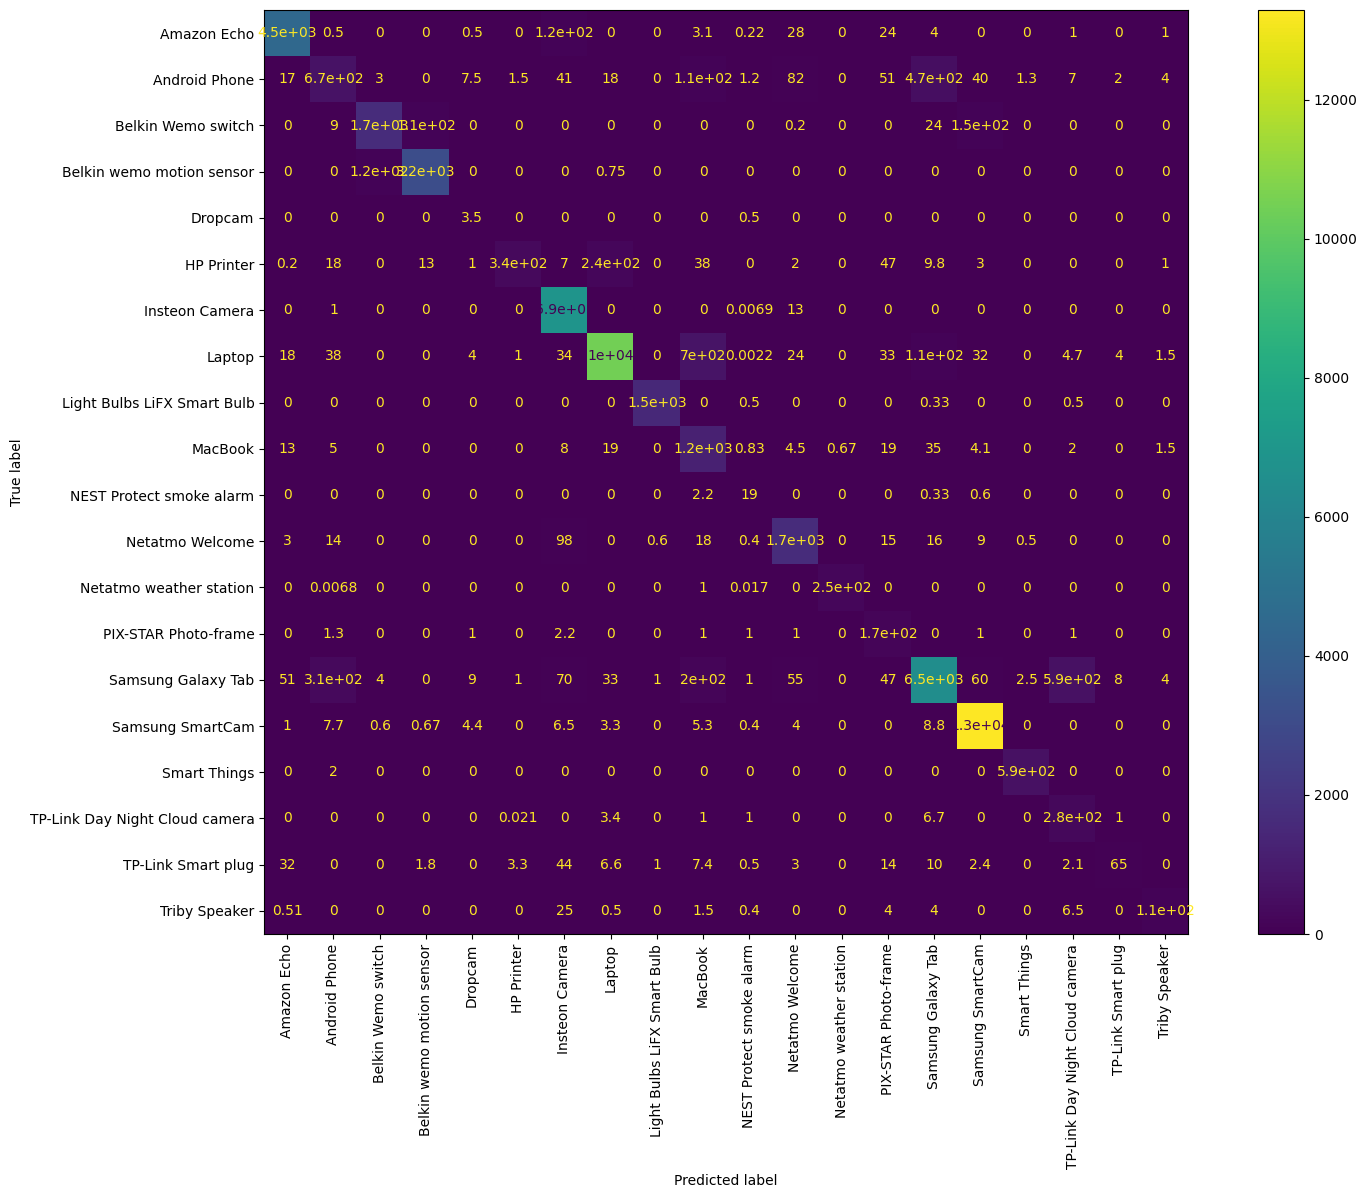

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true=list(expanded_y_true), y_pred=expanded_y_pred, sample_weight=expanded_weights, labels=list(range(0, len(classes))))
#
# plt.figure(figsize=(50,50))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(18,12))
disp.plot(ax=ax)
ax.set_xticklabels(classes, rotation=90)
#
# df_cols = ['Class_Name'] + classes
cm_df = pd.DataFrame(columns=classes)

for i in range(0, len(classes)):
    true_label = cm[i]
    cm_df.loc[len(cm_df.index)] = true_label
cm_df.insert(loc=0, column='Class_Name', value=classes)

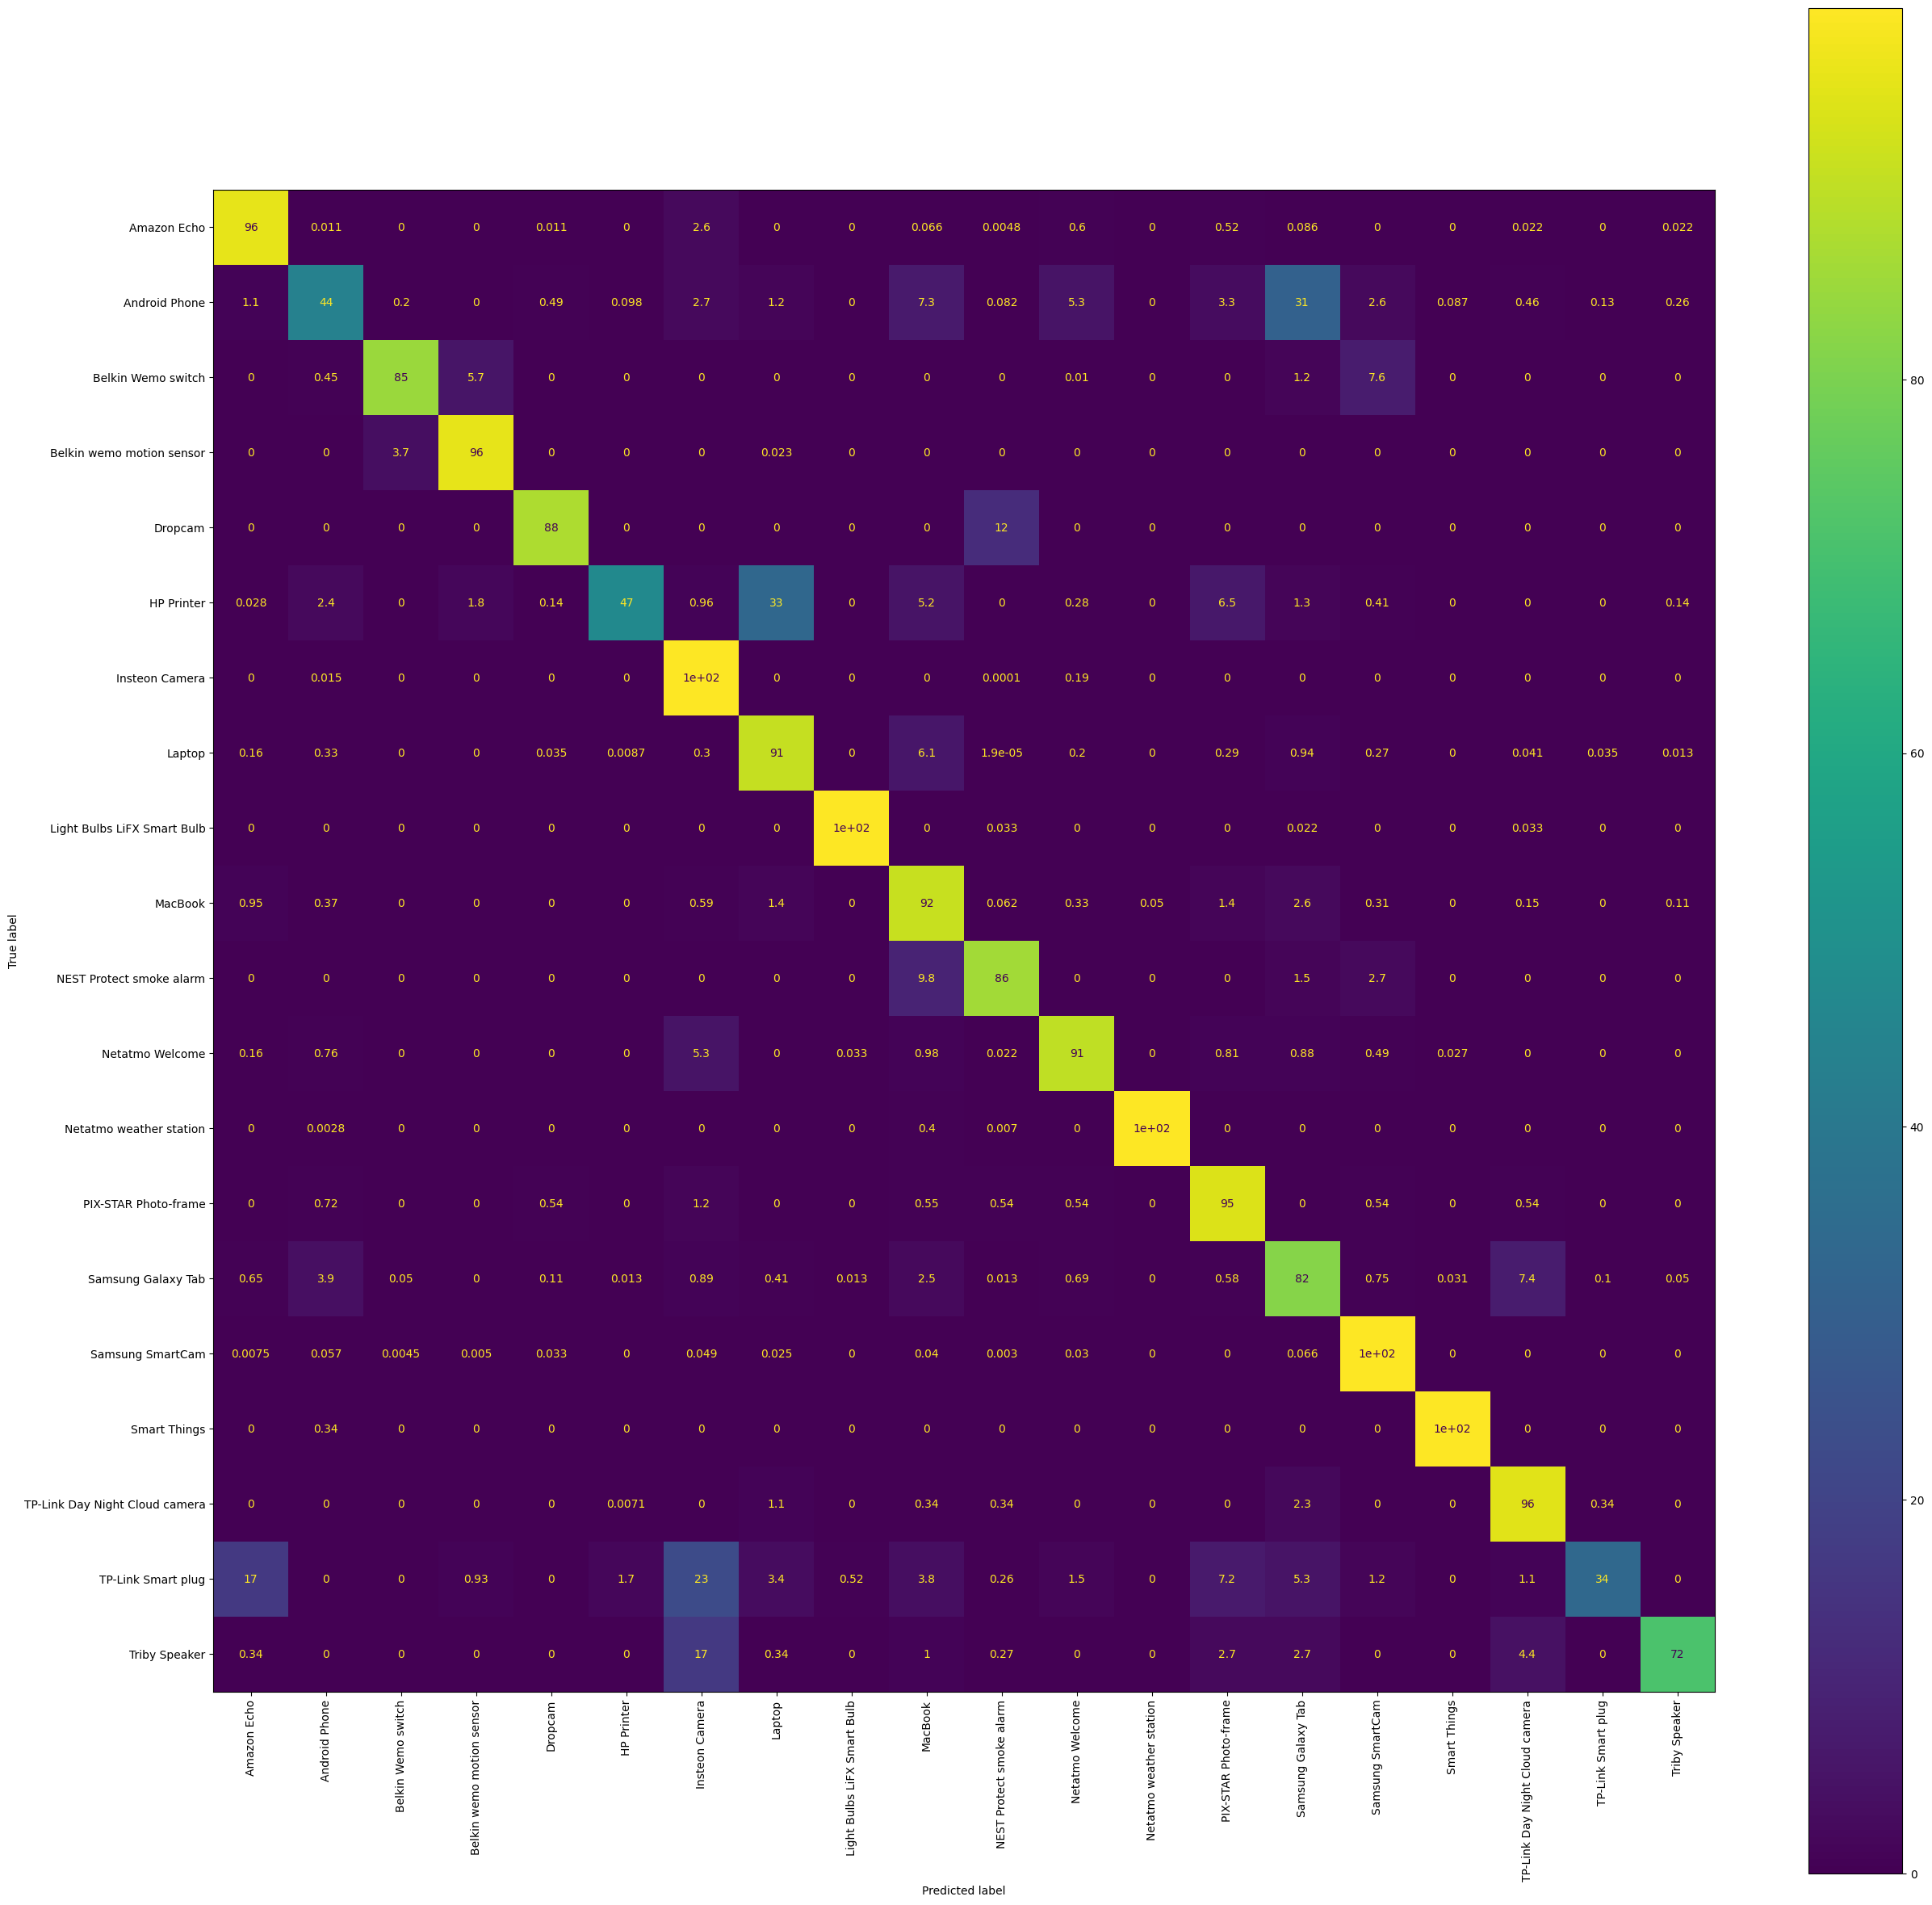

In [26]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# cm = confusion_matrix(y_true=list(y_test), y_pred=y_pred, labels=list(range(0, len(classes))))
cm = confusion_matrix(y_true=list(expanded_y_true), y_pred=expanded_y_pred, sample_weight=expanded_weights, labels=list(range(0, len(classes))))
#
cm_normalized = []
for cl_list in cm:
    if np.sum(cl_list)!=0:
        cm_normalized.append(np.array(cl_list)*100/np.sum(cl_list))
    else:
        cm_normalized.append(np.array(cl_list))
cm_normalized = np.array(cm_normalized)
# cm_normalized
#
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=classes)
fig, ax = plt.subplots(figsize=(30,30))
disp.plot(ax=ax)
ax.set_xticklabels(classes, rotation=90)

#######
## Dataframe ##
cm_normalized_df = pd.DataFrame(columns=classes)

for i in range(0, len(classes)):
    true_label = cm_normalized[i]
    cm_normalized_df.loc[len(cm_normalized_df.index)] = true_label
cm_normalized_df.insert(loc=0, column='Class_Name', value=classes)

#### Order classes in terms of its scores and PLOT F1-score Per Class

In [32]:
class_names = cl_report_FL.keys()
score_per_class = []
classes_ = []
support_values = []

for c_name in class_names:
    if c_name in classes:
        score_per_class.append(cl_report_FL[c_name]['f1-score'])
        classes_.append(c_name)
        support_values.append(cl_report_FL[c_name]['support'])

# classes_.append('IPhone')
# score_per_class.append(0)
# support_values.append(0)
# classes_.append('Blipcare Blood Pressure meter')
# score_per_class.append(0.001)
# support_values.append(0)
score_per_class_df = pd.DataFrame({'class': classes_, 'f1_score': score_per_class, 'support': support_values})
score_per_class_df = score_per_class_df.sort_values(by='f1_score', ascending=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


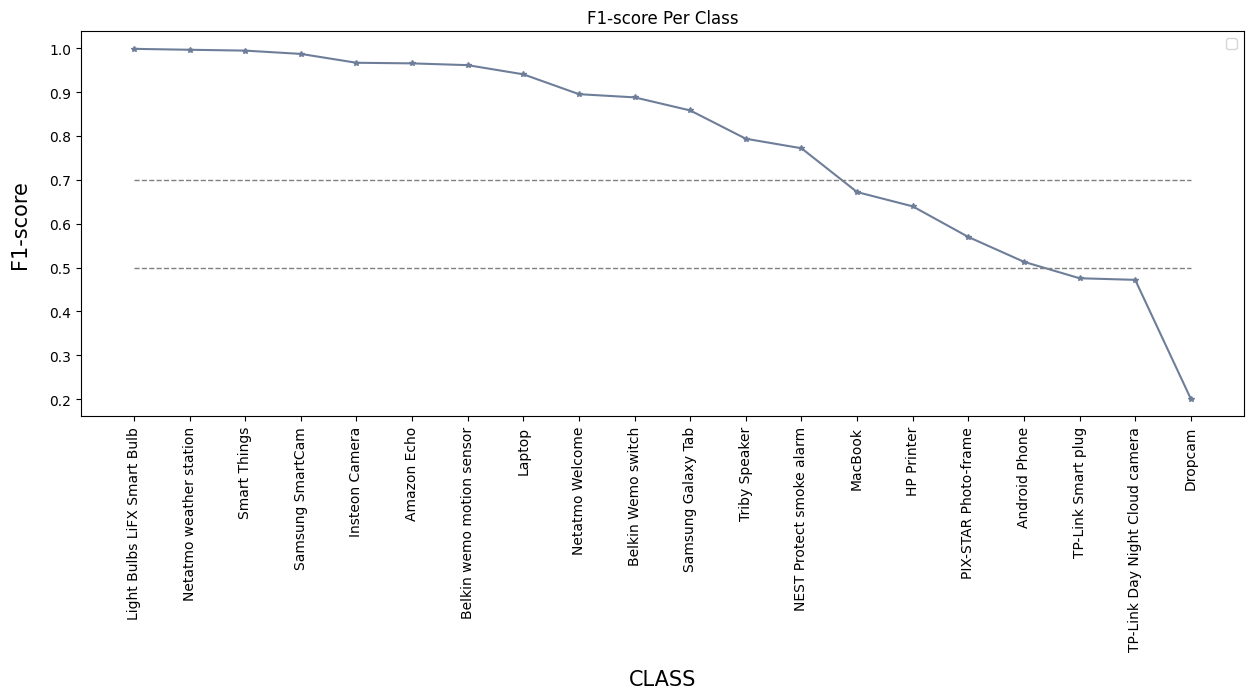

In [33]:
##### TEST
plot_line([score_per_class_df['class'].to_list()], [score_per_class_df['f1_score'].to_list()], [], 'CLASS', 'F1-score', 'F1-score Per Class')

# PCFI
#### Obtaining per-class feature importance

In [34]:
rf_opt = RandomForestClassifier(max_depth = depth, n_estimators = n_tree, random_state=42, bootstrap=False,n_jobs=10)
rf_opt.fit(X_train[feats], y_train, sample_weight=weight_of_samples)

RandomForestClassifier(bootstrap=False, max_depth=23, n_estimators=32,
                       n_jobs=10, random_state=42)

In [35]:
### Matrix containing feature importances per feature-class pair
imp_mat = calcImportanceMatrix(rf_opt)

In [36]:
#### GET ordered classes and GET their features and feature importances in that order
imp_mat_ordered = []
score_per_class_df['f1_score'] = score_per_class_df['f1_score']*100
classes_ordered = score_per_class_df['class'].to_list()
class_scores_ordered = score_per_class_df['f1_score'].to_list()

for cl in classes_ordered:
    ind_of_class = classes.index(cl)
    imp_mat_ordered.append(imp_mat[ind_of_class])
    
## 2 classes which are not in TEST SET
# classes_ordered.append('IPhone')
# class_scores_ordered.append(0)
# imp_mat_ordered.append(imp_mat[classes.index('IPhone')])
# classes_ordered.append('Blipcare Blood Pressure meter')
# class_scores_ordered.append(1)
# imp_mat_ordered.append(imp_mat[classes.index('Blipcare Blood Pressure meter')])

In [37]:
len(classes_ordered)

20

In [38]:
feature_names = feats

## Model analysis results - per cluster

In [39]:
# list of all extracted features
feats_all = ["ip.len",'ip.hdr_len',"ip.ttl","tcp.flags.syn","tcp.flags.ack","tcp.flags.push","tcp.flags.fin","tcp.flags.rst", "tcp.flags.reset",\
            "tcp.flags.ece","ip.proto","srcport","dstport","tcp.window_size_value","tcp.hdr_len","udp.length", 'UDP Len Min', 'UDP Len Max', 'UDP Len Total',\
            "Min Packet Length","Max Packet Length","Packet Length Mean","Packet Length Total",\
                "Flow IAT Min","Flow IAT Max","Flow IAT Mean","Flow Duration",\
                    "SYN Flag Count","ACK Flag Count","PSH Flag Count","FIN Flag Count","RST Flag Count","ECE Flag Count", "Packet Count"]

feats_sizes = [16, 16, 8, 1, 1, 1, 1, 1, 1,
               1, 8, 16, 16, 16, 4, 16, 16, 16, 16,
                16, 16, 16, 16,
                32, 32, 32, 32,
                8, 8, 8, 8, 8, 8, 16]

feats_size_dict = {}
for f_ind in range(0, len(feats_all)):
    feats_size_dict[feats_all[f_ind]] = feats_sizes[f_ind]
    
available_TCAM_table = 24*12

In [40]:
def calculate_score(support_total, mult_score_support, score):
    macro_score = np.mean(np.array(score))
    weighted_score = np.sum(mult_score_support)/support_total
    
    return macro_score, weighted_score

def concat_csvs(path, dir_entries, use_case):
    d_frames = []
    count = 2
    
    for dir_csv in dir_entries:
        f_name = path + dir_csv
        # print(f_name)
        i_df = pd.read_csv(f_name, sep=';')
        # if use_case == 'planter':
        #     i_df['N_Leaves'] = 500
        #     i_df['New_Macro_F1'] = i_df['macro']
        #     i_df['New_Weighted_F1'] = i_df['weighted']
        #     i_df = i_df.loc[~((i_df['tree'] == 5) & (i_df['no_feats']>8))]
        # if use_case == 'flowrest':
        #     i_df['N_Leaves'] = 500
        #     i_df = i_df.loc[~((i_df['tree'] == 5) & (i_df['no_feats']>5))]
        #     i_df = i_df.loc[~((i_df['tree'] == 3) & (i_df['no_feats']>8))]
        #     i_df = i_df[i_df['tree']  != 2]
        #     i_df = i_df[i_df['tree']!= 4]
        if use_case == 'jewel':
            i_df = i_df.loc[~((i_df['tree'] == 5) & (i_df['no_feats']>4))]
            i_df = i_df.loc[~((i_df['tree'] == 3) & (i_df['no_feats']>7))]
            i_df = i_df[i_df['tree']  != 2]
            i_df = i_df[i_df['tree']!= 4]

        i_df = i_df[['depth','tree', 'no_feats', 'New_Macro_F1', 'New_Weighted_F1', 'N_Leaves', 'feats']]
        # i_df = i_df[i_df['depth'] > 8]
        i_df = i_df[i_df['tree'] < 6]
        # i_df = i_df[i_df['tree']  != 2]
        # i_df = i_df[i_df['tree']!= 4]
        i_df = i_df[i_df['no_feats'] < 11]
        i_df = i_df[i_df['N_Leaves'] > 120]
        i_df['N'] = count
        i_df['F1_score'] = i_df.apply(lambda x: 0.5*(x['New_Macro_F1'] + x['New_Weighted_F1']), axis=1)
        # i_df['F1_score'] = i_df['New_Macro_F1']
        d_frames.append(i_df)
        # print(len(i_df))
        count = count + 1
        
    # print(d_frames)
    return pd.concat(d_frames)

def calculate_tcam_for_codetables(models_df):
    
    models_df['tcam_codetable'] = models_df.apply(lambda x: (int(x['N_Leaves']/44) + 1)*x['tree'], axis=1)

    return models_df

def calculate_tcam_for_featable(models_df):
    feats_for_all_models = list(models_df['feats'])
    tcam_usage_per_model = []
    for feats_in_models in feats_for_all_models:
        feats_in_models_list = feats_in_models[2:][:-2].split('\', \'')
        tcam_usage = 0
        # print(feats_in_models_list)
        for feat in feats_in_models_list:
            # print(feat)
            bit_length = feats_size_dict[feat]
            tcam_usage = tcam_usage + int((2*bit_length)/44) +1
            # print(bit_length, tcam_usage)
        
        tcam_usage_per_model.append(tcam_usage) 
    models_df['tcam_feature_table'] = tcam_usage_per_model
    return models_df

def total_tcam_usage(models_df):
    models_df['total_tcam_tbl_usage'] = models_df.apply(lambda x: x['tcam_feature_table'] + x['tcam_codetable'], axis=1)
    models_df['total_tcam_usage'] = models_df.apply(lambda x: x['total_tcam_tbl_usage']/available_TCAM_table, axis=1)
    # models_df['success_score'] = models_df.apply(lambda x: 0.5*(x['F1_score'] + (1-x['total_tcam_usage']) ), axis=1)
    # models_df['penalty'] = np.where(models_df['tree'] == 5, 1, 0)
    models_df['success_score'] = models_df.apply(lambda x: (0.5*x['Avg_F1_score'] + 0.5*(1-x['total_tcam_usage'])), axis=1)
    return models_df

def plot_scatter(x, y, x1, y1, xlabel, ylabel, name, outfile):

    font = {'family': 'sans-serif',
            'weight': 'normal',
            'size': 19}
    plt.rc('font', **font)

    plt.figure(figsize=(5, 4))
    
    if name == 'jewel':
        plt.scatter(x, y, c='#6E7E99', alpha=0.28, edgecolors='none')
    else:
        plt.scatter(x, y, c='#6E7E99', alpha=0.5, edgecolors='none')
    # plt.scatter(x1, y1, c='#E06B5A', alpha=1, edgecolors='none')
    plt.scatter(x1, y1, c='#EE4B2B', alpha=1, edgecolors='none', s=200)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(0,25)
    plt.ylim(0,105)
    plt.xticks([0, 5, 10, 15, 20, 25])
    
    # plt.savefig(outfile, dpi=200, bbox_inches='tight', pad_inches=0.1)
    
    plt.show()

In [ ]:
def select_best_models_per_cluster(n_values, n_of_clusters, total_n_classes, cluster_info, score_per_class_df, type_of_run, folder_name, use_case):
    
    ### For each cluster 
    for cl in range(0, n_of_clusters):
        d_frames = []
        ### For each value of N
        for nd in n_values:
            #### Get the related model analysis file and concat with the nd value
            if type_of_run=="With_Others":
                f_name = folder_name + "/" + use_case + "_models_"+str(nd)+"pkts_PF_WB_" + str(total_n_classes) + "CL_Cluster" + str(cl) + "_11CLUSTER.csv"
                # f_name = folder_name + "/" + use_case + "_models_"+str(nd)+"pkts_PF_WB_" + str(total_n_classes) + "CL_Cluster" + str(cl) + ".csv"
                # f_name = folder_name + "/" + use_case + "_models_"+str(nd)+"pkts_PF_WB_" + str(total_n_classes) + "CL_Cluster" + str(cl) + "_newHamming_WithOther.csv"
            elif type_of_run=="Ordered":
                # f_name = folder_name + "/" + use_case + "_models_"+str(nd)+"pkts_PF_WB_" + str(total_n_classes) + "CL_Cluster" + str(cl) + "_MACRO_Ordered_by_score_change_support.csv"
                # f_name = folder_name + "/" + use_case + "_models_"+str(nd)+"pkts_PF_WB_" + str(total_n_classes) + "CL_Cluster" + str(cl) + "_MACRO_Ordered_CM.csv"
                # f_name = folder_name + "/" + use_case + "_models_"+str(nd)+"pkts_PF_WB_" + str(total_n_classes) + "CL_Cluster" + str(cl) + "_MACRO_Ordered_by_score_change_totalFN_avg_score.csv"
                # f_name = folder_name + "/" + use_case + "_models_"+str(nd)+"pkts_PF_WB_" + str(total_n_classes) + "CL_Cluster" + str(cl) + "_MACRO_Ordered_Opt_F1_x_FP_30642157.csv"
                # f_name = folder_name + "/" + use_case + "_models_"+str(nd)+"pkts_PF_WB_" + str(total_n_classes) + "CL_Cluster" + str(cl) + "_MACRO_Ordered_Opt_F1_x_FP_x_score_change_CUMULATIVE_34215067.csv"
                # f_name = folder_name + "/" + use_case + "_models_"+str(nd)+"pkts_PF_WB_" + str(total_n_classes) + "CL_Cluster" + str(cl) + "_MACRO_Ordered_Opt_F1_x_FP_CUMULATIVE_23064157.csv"
                # f_name = folder_name + "/" + use_case + "_models_"+str(nd)+"pkts_PF_WB_" + str(total_n_classes) + "CL_Cluster" + str(cl) + "_MACRO_Ordered_Opt_F1_x_FP_x_score_change_CUMULATIVE_Optimizer_73421506.csv"
                # f_name = folder_name + "/" + use_case + "_models_"+str(nd)+"pkts_PF_WB_" + str(total_n_classes) + "CL_Cluster" + str(cl) + "_MACRO_Ordered_Opt_F1_x_FP_x_score_change_CUMULATIVE_Optimizer_34215706.csv"
                # f_name = folder_name + "/" + use_case + "_models_"+str(nd)+"pkts_PF_WB_" + str(total_n_classes) + "CL_Cluster" + str(cl) + "_MACRO_Ordered_Opt_F1_x_FP_x_score_change_CUMULATIVE_Optimizer_34215076.csv"
                # f_name = folder_name + "/" + use_case + "_models_"+str(nd)+"pkts_PF_WB_" + str(total_n_classes) + "CL_Cluster" + str(cl) + "_MACRO_Ordered_Opt_F1_x_FP_x_score_change_CUMULATIVE_Optimizer_12356407.csv"
                # f_name = folder_name + "/" + use_case + "_models_"+str(nd)+"pkts_PF_WB_" + str(total_n_classes) + "CL_Cluster" + str(cl) + "_MACRO_Ordered_withOptimizer_6June_37514620.csv"
                # f_name = folder_name + "/" + use_case + "_models_"+str(nd)+"pkts_PF_WB_" + str(total_n_classes) + "CL_Cluster" + str(cl) + "_MACRO_Ordered_withOptimizer_deltaF1J_13June_51467203.csv"
                f_name = folder_name + "/" + use_case + "_models_"+str(nd)+"pkts_PF_WB_" + str(total_n_classes) + "CL_Cluster" + str(cl) + "_MACRO_Ordered_withOptimizer_NOdelta_13June_75314620.csv"

            else:
                f_name = folder_name + "/" + use_case + "_models_"+str(nd)+"pkts_PF_WB_" + str(total_n_classes) + "CL_Cluster" + str(cl) + "_WithoutOther.csv"
                # f_name = folder_name + "/" + use_case + "_models_"+str(nd)+"pkts_PF_WB_" + str(total_n_classes) + "CL_Cluster" + str(cl) + "_newHamming_WithoutOther.csv"
            try:
                model_analysis_for_nth = pd.read_csv(f_name, sep=';')
            except:
                print(f_name)
                continue
            model_analysis_for_nth['N'] = nd
            #
            model_analysis_for_nth['Avg_F1_score'] = model_analysis_for_nth.apply(lambda x: (1)*(x['Macro_f1_FL']), axis=1) ###?? MICRO ? 
            # model_analysis_for_nth['Avg_F1_score'] = model_analysis_for_nth.apply(lambda x: (0.5)*(x['Macro_f1_FL'] + x['Weighted_f1_FL']), axis=1) ###?? MICRO ? 
            # model_analysis_for_nth['Avg_F1_score'] = model_analysis_for_nth.apply(lambda x: (1/3)*(x['Macro_f1_FL'] + x['Weighted_f1_FL'] + x['Micro_f1_FL']), axis=1) ###?? MICRO ? 
            d_frames.append(model_analysis_for_nth)
        models_for_cluster = pd.concat(d_frames)
        models_for_cluster = models_for_cluster.reset_index()
        
        #### Calculate TOTAL TCAM usage and calculate SUCCESS SCORE
        models_with_tcam_info = calculate_tcam_for_codetables(models_for_cluster)
        models_with_tcam_info = calculate_tcam_for_featable(models_with_tcam_info)
        models_with_tcam_info = total_tcam_usage(models_with_tcam_info)
        ####
        
        #### ORDER in terms of SUCCESS SCORE and choose the BEST
        # print(models_with_tcam_info.sort_values('success_score', ascending=0).head(1))
        chosen_model_tcam_usage = models_with_tcam_info.sort_values('success_score', ascending=0)['total_tcam_usage'].to_list()[0]*100
        chosen_model_avg_f1_score = models_with_tcam_info.sort_values('success_score', ascending=0)['Avg_F1_score'].to_list()[0]*100
        chosen_model_index = models_with_tcam_info.sort_values('success_score', ascending=0).head(1).index.to_list()[0]
        # print(chosen_model_index, chosen_model_tcam_usage, chosen_model_avg_f1_score)
        ####
        
        chosen_model = models_with_tcam_info.loc[chosen_model_index]
        
        #### Store the information of chosen model
        
        cl_report = convert_str_to_dict(chosen_model['cl_report_FL'])
        # if type_of_run=="Ordered":
        cluster_info.loc[cluster_info['Cluster'] == cl, 'Depth_' + type_of_run] = chosen_model['depth']
        # else:
        #     cluster_info.loc[cluster_info['Cluster'] == cl, 'Depth_' + type_of_run] = int(chosen_model['depth'])
        cluster_info.loc[cluster_info['Cluster'] == cl, 'Tree_' + type_of_run] = int(chosen_model['tree'])
        cluster_info.loc[cluster_info['Cluster'] == cl, 'Feats_' + type_of_run] = int(chosen_model['no_feats'])
        cluster_info.loc[cluster_info['Cluster'] == cl, 'Feats_Names_' + type_of_run] = chosen_model['feats']
        cluster_info.loc[cluster_info['Cluster'] == cl, 'N_Leaves_' + type_of_run] = int(chosen_model['N_Leaves'])
        cluster_info.loc[cluster_info['Cluster'] == cl, 'N_' + type_of_run] = int(chosen_model['N'])
        cluster_info.loc[cluster_info['Cluster'] == cl, 'Macro_f1_FL_' + type_of_run] = chosen_model['Macro_f1_FL']*100
        cluster_info.loc[cluster_info['Cluster'] == cl, 'Weighted_f1_FL_' + type_of_run] = chosen_model['Weighted_f1_FL']*100
        cluster_info.loc[cluster_info['Cluster'] == cl, 'Micro_f1_FL_' + type_of_run] = chosen_model['Micro_f1_FL']*100
        cluster_info.loc[cluster_info['Cluster'] == cl, 'Total_TCAM_Usage_' + type_of_run] = chosen_model['total_tcam_usage']*100
        #
        result_dict = {}
        for d_keys in cl_report.keys():
            if (d_keys != 'accuracy') and (d_keys != 'micro avg'):
                result_dict[d_keys] = cl_report[d_keys]['f1-score']
                if d_keys in classes:
                    df_col = 'Cluster_F1_Score_' + type_of_run
                    score_per_class_df.loc[score_per_class_df['class'] == d_keys, df_col] = cl_report[d_keys]['f1-score']*100
                    score_per_class_df.loc[score_per_class_df['class'] == d_keys, 'Cluster'] = cl
        ####
        
        #### PLOT the chosen model (SCATTER) ####
        # tcam_usage = list(models_with_tcam_info['total_tcam_usage'])
        # weighted_scores = list(models_with_tcam_info['Avg_F1_score'])
        
        # x = [i * 100 for i in tcam_usage]
        # y = [i * 100 for i in weighted_scores]

        # plot_scatter(x, y, chosen_model_tcam_usage, chosen_model_avg_f1_score, "Usage of TCAM Resources [%]", "", 'jewel', 'model_analysis_results/unibs_jewel_Success.pdf')
        ####

    return cluster_info, score_per_class_df

In [ ]:
### Initialize dataframes to use for statistics
total_n_classes = 24
n_of_clusters = 11
cluster_info = pd.read_csv('/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/cluster_info_W_'+str(total_n_classes)+'CL_'+str(n_of_clusters)+'cluster.csv', sep=',')
# cluster_info = pd.read_csv('/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/cluster_info_W_'+str(total_n_classes)+'CL_'+str(n_of_clusters)+'cluster_DiffHammingDistance.csv', sep=',')
# print(cluster_info)
cluster_info = cluster_info[['Cluster', 'Class List', 'Feature List']]
# cluster_info['N'] = [-1]*len(cluster_info)
score_per_class_df['Cluster'] = [-1]*len(score_per_class_df)
score_per_class_df['Cluster_F1_Score_With_Others'] = [-1]*len(score_per_class_df)
score_per_class_df['Cluster_F1_Score_Without_Others'] = [-1]*len(score_per_class_df)

In [ ]:
cluster_info, score_per_clas_per_class_df = select_best_models_per_cluster([2,3,4], n_of_clusters, total_n_classes, cluster_info, score_per_class_df, "With_Others", '/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/cluster_model_analysis_results/Proportional_fairness', 'unsw')
# cluster_info, scores_df = select_best_models_per_cluster([2,3], n_of_clusters, total_n_classes, cluster_info, score_per_class_df, "Without_Others", '/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/cluster_model_analysis_results/Proportional_fairness/24CL', 'unsw')
# cluster_info, score_per_class_df = select_best_models_per_cluster([2,3,4], n_of_clusters, total_n_classes, cluster_info, score_per_class_df, "Ordered", '/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/cluster_model_analysis_results/Proportional_fairness', 'unsw')

In [30]:
# cluster_info[['Cluster', 'Class List', 'Depth_Ordered', 'Tree_Ordered', 'Feats_Ordered', 'N_Leaves_Ordered', 'N_Ordered', 'Total_TCAM_Usage_Ordered', 'Macro_f1_FL_Ordered', 'Weighted_f1_FL_Ordered', 'Micro_f1_FL_Ordered']]

In [31]:
## total TCAM usage
# print(sum(cluster_info['Total_TCAM_Usage_Ordered'].to_list()[1:]))
print(sum(cluster_info['Total_TCAM_Usage_With_Others'].to_list()[1:]))
# print(sum(cluster_info['Total_TCAM_Usage_Without_Others'].to_list()[1:]))

39.23611111111111


In [118]:
# cluster_info[['Cluster', 'Class List', 'Feats_Names_With_Others', 'Depth_With_Others', 'Tree_With_Others', 'Feats_With_Others', 'N_Leaves_With_Others', 'N_With_Others', 'Total_TCAM_Usage_With_Others', 'Macro_f1_FL_With_Others', 'Weighted_f1_FL_With_Others', 'Micro_f1_FL_With_Others']]

In [119]:
# cluster_info[['Cluster', 'Class List', 'Feats_Names_Without_Others', 'Depth_Without_Others', 'Tree_Without_Others', 'Feats_Without_Others', 'N_Leaves_Without_Others', 'N_Without_Others', 'Total_TCAM_Usage_Without_Others']]

#### To calculate overall scores

In [32]:
##### SCORE CALCULATION #####
### With Unsuccessful Classes
score_calc_df = score_per_class_df[score_per_class_df['f1_score']>5]
score_calc_df['mult_With_Others'] = score_calc_df['Cluster_F1_Score_With_Others']*score_calc_df['support']
# score_calc_df['mult_Without_Others'] = score_calc_df['Cluster_F1_Score_Without_Others']*score_calc_df['support']
# score_calc_df['mult_Ordered'] = score_calc_df['Cluster_F1_Score_Ordered']*score_calc_df['support']
##
print('After the clustering with ALL: ', calculate_score(np.sum(np.array(score_calc_df['support'])), score_calc_df['mult_With_Others'], score_calc_df['Cluster_F1_Score_With_Others']))
# print('After the clustering with ALL: ', calculate_score(np.sum(np.array(score_calc_df['support'])), score_calc_df['mult_Without_Others'], score_calc_df['Cluster_F1_Score_Without_Others']))
# print('After the clustering with ALL: ', calculate_score(np.sum(np.array(score_calc_df['support'])), score_calc_df['mult_Ordered'], score_calc_df['Cluster_F1_Score_Ordered']))


After the clustering with ALL:  (79.3030502596799, 87.22167193312072)


#### To have ordered clusters with model selections

In [28]:
# rate_for_ordering_df = pd.read_csv('/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/cluster_RATE_data_24CL_MACRO_rate_by_score_change_support.csv', sep=',')
# rate_for_ordering_df = pd.read_csv('/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/cluster_RATE_data_24CL_MACRO_rate_by_score_change_total_FN_avg_score.csv', sep=',')
# rate_for_ordering_df = pd.read_csv('/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/cluster_RATE_data_24CL_MACRO_rate_by_CM.csv', sep=',')
# rate_for_ordering_df = rate_for_ordering_df.sort_values(by='Rate_FN', ascending=True)
rate_for_ordering_df = pd.read_csv('/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/cluster_order_24CL_MACRO_withOptimizer_6June_37514620.csv', sep=',')

In [29]:
rate_for_ordering_df[['Cluster']].merge(cluster_info, on='Cluster')[['Cluster', 'Class List', 'Depth_Ordered', 'Tree_Ordered', 'Feats_Ordered', 'N_Leaves_Ordered', 'N_Ordered', 'Total_TCAM_Usage_Ordered', 'Macro_f1_FL_Ordered', 'Weighted_f1_FL_Ordered', 'Micro_f1_FL_Ordered']]

,Cluster,Class List,Depth_Ordered,Tree_Ordered,Feats_Ordered,N_Leaves_Ordered,N_Ordered,Total_TCAM_Usage_Ordered,Macro_f1_FL_Ordered,Weighted_f1_FL_Ordered,Micro_f1_FL_Ordered
0,0,"['PIX-STAR Photo-frame', 'Android Phone', 'TP-...",[14],1.0,6.0,173.0,2.0,3.472222,88.603924,93.580374,93.358500
1,2,"['MacBook', 'HP Printer']",[17],1.0,4.0,173.0,2.0,2.777778,88.967034,89.229136,89.167163
2,6,"['Samsung Galaxy Tab', 'Triby Speaker']","[26, 20]",2.0,5.0,349.0,2.0,7.291667,76.599321,77.414727,76.915810
3,4,"['Netatmo Welcome', 'Belkin Wemo switch']",[15],1.0,5.0,129.0,2.0,2.777778,96.805623,98.084654,98.089357
4,7,['Dropcam'],[11],1.0,3.0,41.0,2.0,1.736111,96.665806,99.996816,99.996919
5,1,"['Samsung SmartCam', 'Amazon Echo', 'Belkin we...","[21, 23]",2.0,8.0,393.0,2.0,9.027778,92.992498,93.170121,93.177581
6,5,"['NEST Protect smoke alarm', 'Withings Smart B...","[12, 12, 18, 11]",4.0,6.0,85.0,2.0,5.208333,88.227211,98.877069,98.971837
7,3,"['Light Bulbs LiFX Smart Bulb', 'Netatmo weath...",[10],1.0,4.0,41.0,3.0,1.736111,99.157367,99.907775,99.908167


### Metric to rate clusters - ORDER of CLUSTERS

In [25]:
cluster_rating = cluster_info.copy()
cluster_rating = cluster_rating[cluster_rating['Cluster'] != -1]
# cluster_rating['Average_F1_With_Others'] = (cluster_rating['Macro_f1_FL_With_Others'] + cluster_rating['Weighted_f1_FL_With_Others'] + cluster_rating['Micro_f1_FL_With_Others'])*(1/3)
# cluster_rating['Average_F1_With_Others'] = (cluster_rating['Macro_f1_FL_With_Others'] + cluster_rating['Weighted_f1_FL_With_Others'])*(1/2)
cluster_rating['Average_F1_With_Others'] = cluster_rating['Macro_f1_FL_With_Others']
# cluster_rating['Average_F1_Without_Others'] = (cluster_rating['Macro_f1_FL_Without_Others'] + cluster_rating['Weighted_f1_FL_Without_Others'] + cluster_rating['Micro_f1_FL_Without_Others'])*(1/3)
# cluster_rating['Average_F1_Without_Others'] = (cluster_rating['Macro_f1_FL_Without_Others'] + cluster_rating['Weighted_f1_FL_Without_Others'])*(1/2)
cluster_rating['Average_F1_Without_Others'] = cluster_rating['Macro_f1_FL_Without_Others']
cluster_rating = cluster_rating[['Cluster', 'Class List', 'Average_F1_With_Others', 'Average_F1_Without_Others']]
##
score_per_class_CL_df = score_per_class_df.copy()
score_per_class_CL_df['F1_score_difference'] = score_per_class_CL_df['Cluster_F1_Score_Without_Others'] - score_per_class_CL_df['Cluster_F1_Score_With_Others']
##
cluster_list = cluster_rating['Class List'].to_list()
avg_score_change = []
total_n_samples = []
n_of_classes = []
for cl in cluster_list:
    cl_list = cl[2:-2].split("', '")
    score_per_class = score_per_class_CL_df[score_per_class_CL_df['class'].isin(cl_list)]
    avg_score_change.append(np.mean(score_per_class['F1_score_difference'].to_list()))
    total_n_samples.append(int(np.sum(score_per_class['support'].to_list())))
    n_of_classes.append(int(len(score_per_class)))
cluster_rating['Avg_F1_score_change'] = avg_score_change
cluster_rating['Support'] = total_n_samples
cluster_rating['Number_of_classes'] = n_of_classes


In [26]:
# cluster_rating.to_csv('Score_change_per_cluster_wot_others.csv')

In [27]:
### Get the information of FP, FN
cluster_list = cluster_rating['Cluster'].to_list()
class_list = cluster_rating['Class List'].to_list()
the_effect = []
cm_df = cm_df
for cl_1 in cluster_list:
    FN = []
    FP = []
    total_FN_FP = []
    cl_list_1 = class_list[cl_1][2:-2].split("', '")
    for cl_2 in cluster_list:
        if cl_1==cl_2:
            FN.append(0)
            FP.append(0)
            total_FN_FP.append(0)
        else:
            cl_list_2 = class_list[cl_2][2:-2].split("', '")
            total_FN = 0
            total_FP = 0
            total_FN_FP_val = 0
            for c1 in cl_list_1:
                for c2 in cl_list_2:    
                    # True Label == c2 -- Predicted Label == c1
                    # temp_cm_df = cm_df[['Class_Name', c1]]
                    total_FP = total_FP + cm_df[cm_df['Class_Name'] == c2][c1].to_list()[0]
                    
                    # True Label == c1 -- Predicted Label == c2
                    temp_cm_df = cm_df[cm_df['Class_Name'] == c1]
                    total_FN = total_FN + temp_cm_df[c2].to_list()[0]
                    total_FN_FP_val = total_FN + total_FP
            FN.append(total_FN)
            FP.append(total_FP)
            total_FN_FP.append(total_FN_FP_val)
    print([(x/sum(FN))*100 for x in FN])
    # FN = [(x/sum(FN))*100 for x in FN]
    # FP = [(x/sum(FP))*100 for x in FP]
    # total_FN_FP = [(x/sum(total_FN_FP))*100 for x in total_FN_FP]
    # the_effect.append(sum(FN))
    cluster_rating['CL'+str(cl_1)] = FP
    # cluster_rating['CL'+str(cl_1)+'_FP'] = FP
    # cluster_rating['CL'+str(cl_1)] = total_FN_FP
# cluster_rating['EFFECT_FP'] = the_effect
cluster_rating['EFFECT_FN'] = cluster_rating['CL0'] + cluster_rating['CL1'] + cluster_rating['CL2'] + cluster_rating['CL3'] + cluster_rating['CL4'] + cluster_rating['CL5'] + cluster_rating['CL6'] +cluster_rating['CL7']
                

[0.0, 23.621955525907936, 13.477334265058058, 0.34097595402993663, 9.814992836751728, 0.6009701189777634, 51.212906944772854, 0.9308643545017271]
[6.635729654686163, 0.0, 48.712755826867614, 0.24662348848156382, 12.51078209894545, 22.670403632520685, 8.621715053407433, 0.6019902450910746]
[19.899345504315182, 67.77406270305491, 0.0, 0.1493158256957091, 1.4506606757975429, 0.5226053899349817, 9.98003616265812, 0.22397373854356364]
[46.799239588737, 0.0, 18.65007313925065, 0.0, 0.0, 9.659056322159953, 24.8916309498524, 0.0]
[8.616201335634306, 80.04371797637903, 3.844704162276854, 0.23714997636474053, 0.0, 0.08623635504172382, 6.956399306699054, 0.21559088760430956]
[0.5113709365687163, 97.82895457465497, 1.107299272097614, 0.0, 0.0, 0.0, 0.552375216678694, 0.0]
[65.95690771387152, 14.771438190195516, 13.503917923067677, 0.23656668135389777, 4.476931306400961, 0.44592386162899567, 0.0, 0.6083143234814514]
[0.0, 0.0, 0.0, 0.0, 0.0, 100.0, 0.0, 0.0]


In [28]:
# cluster_rating[['Cluster', 'CL0', 'CL1', 'CL2', 'CL3', 'CL4', 'CL5', 'CL6', 'CL7']]

In [29]:
# # from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# # cm = confusion_matrix(y_true=list(y_test), y_pred=y_pred, labels=list(range(0, len(classes))))
# cm = cluster_rating[['CL0', 'CL1', 'CL2', 'CL3', 'CL4', 'CL5', 'CL6', 'CL7']].to_numpy()
# #
# cm_normalized = []
# for cl_list in cm:
#     if np.sum(cl_list)!=0:
#         cm_normalized.append(np.array(cl_list)*100/np.sum(cl_list))
#     else:
#         cm_normalized.append(np.array(cl_list))
# cm_normalized = np.array(cm_normalized)
# # cm_normalized
# #
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# fig, ax = plt.subplots(figsize=(12,12))
# disp.plot(ax=ax)
# # ax.set_xticklabels(['CL0', 'CL1', 'CL2', 'CL3', 'CL5', 'CL6', 'CL7'], rotation=90)


In [30]:
# cluster_rating[['Cluster', 'Class List', 'EFFECT_FN', 'Average_F1_With_Others', 'Avg_F1_score_change', 'Support']]

In [31]:
cluster_RATE_data = cluster_rating[['Cluster', 'Class List', 'EFFECT_FN', 'Average_F1_With_Others', 'Avg_F1_score_change', 'Support']]
# cluster_RATE_data['EFFECT'] = cluster_RATE_data['EFFECT_FP'] + cluster_RATE_data['EFFECT_FN']
# cluster_RATE_data['EFFECT'] = cluster_RATE_data['EFFECT']/sum(cluster_RATE_data['EFFECT'].to_list())
# cluster_RATE_data['EFFECT_FP'] = cluster_RATE_data['EFFECT_FP']/sum(cluster_RATE_data['EFFECT_FP'].to_list())
cluster_RATE_data['EFFECT_FN'] = cluster_RATE_data['EFFECT_FN']/sum(cluster_RATE_data['EFFECT_FN'].to_list())
cluster_RATE_data['Average_F1_With_Others'] = cluster_RATE_data['Average_F1_With_Others']/sum(cluster_RATE_data['Average_F1_With_Others'].to_list())
cluster_RATE_data['Avg_F1_score_change'] = cluster_RATE_data['Avg_F1_score_change']/sum(cluster_RATE_data['Avg_F1_score_change'].to_list())
cluster_RATE_data['Support'] = cluster_RATE_data['Support']/sum(cluster_RATE_data['Support'].to_list())
cluster_RATE_data

,Cluster,Class List,EFFECT_FN,Average_F1_With_Others,Avg_F1_score_change,Support
1,0,"['PIX-STAR Photo-frame', 'Android Phone', 'TP-...",0.182781,0.085152,0.335867,0.035923
2,1,"['Samsung SmartCam', 'Amazon Echo', 'Belkin we...",0.276425,0.128637,0.069135,0.666945
3,2,"['MacBook', 'HP Printer']",0.083479,0.121124,0.133782,0.033798
4,3,"['Light Bulbs LiFX Smart Bulb', 'Netatmo weath...",0.001002,0.144346,0.003709,0.038409
5,4,"['Netatmo Welcome', 'Belkin Wemo switch']",0.086725,0.134960,0.078664,0.062919
6,5,"['NEST Protect smoke alarm', 'Withings Smart B...",0.092870,0.129616,0.124090,0.029350
7,6,"['Samsung Galaxy Tab', 'Triby Speaker']",0.276625,0.115833,0.198597,0.132607
8,7,['Dropcam'],0.000093,0.140331,0.056155,0.000049


In [99]:
# cluster_RATE_data['Rate_score_change'] = (cluster_RATE_data['Avg_F1_score_change'])
# cluster_RATE_data = cluster_RATE_data.sort_values(by='Rate_score_change', ascending=True)
# cluster_RATE_data
# # cluster_RATE_data = cluster_RATE_data.sort_values(by='Rate_score_change')

In [211]:
# cluster_RATE_data['Rate_score_change_support'] = (cluster_RATE_data['Avg_F1_score_change'])/(cluster_RATE_data['Support'])
# cluster_RATE_data = cluster_RATE_data.sort_values(by='Rate_score_change_support', ascending=False)
# cluster_RATE_data
# # cluster_RATE_data = cluster_RATE_data.sort_values(by='Rate_score_change')

In [210]:
# cluster_RATE_data['Rate_FN'] = (cluster_RATE_data['Avg_F1_score_change']*cluster_RATE_data['EFFECT_FN'])/(cluster_RATE_data['Average_F1_With_Others'])
# cluster_RATE_data = cluster_RATE_data.sort_values(by='Rate_FN', ascending=False)
# cluster_RATE_data
# # order_of_clusters_by_rate = cluster_RATE_data.sort_values(by='Rate')['Cluster'].to_list()

In [97]:
#### Give the order of cluster manually
df_temp = pd.DataFrame()
df_temp['Cluster'] = [7,0,2,6,4,1,3,5]
cluster_RATE_data = df_temp.merge(right=cluster_RATE_data,on='Cluster')

In [98]:
cluster_RATE_data

,Cluster,Class List,EFFECT_FN,Average_F1_With_Others,Avg_F1_score_change,Support,Other_Classes
0,7,['Dropcam'],0.000093,0.140331,0.056155,0.000049,"[PIX-STAR Photo-frame, Android Phone, TP-Link ..."
1,0,"['PIX-STAR Photo-frame', 'Android Phone', 'TP-...",0.182781,0.085152,0.335867,0.035923,[]
2,2,"['MacBook', 'HP Printer']",0.083479,0.121124,0.133782,0.033798,"[PIX-STAR Photo-frame, Android Phone, TP-Link ..."
3,6,"['Samsung Galaxy Tab', 'Triby Speaker']",0.276625,0.115833,0.198597,0.132607,"[PIX-STAR Photo-frame, Android Phone, TP-Link ..."
4,4,"['Netatmo Welcome', 'Belkin Wemo switch']",0.086725,0.134960,0.078664,0.062919,"[PIX-STAR Photo-frame, Android Phone, TP-Link ..."
5,1,"['Samsung SmartCam', 'Amazon Echo', 'Belkin we...",0.276425,0.128637,0.069135,0.666945,"[PIX-STAR Photo-frame, Android Phone, TP-Link ..."
6,3,"['Light Bulbs LiFX Smart Bulb', 'Netatmo weath...",0.001002,0.144346,0.003709,0.038409,"[PIX-STAR Photo-frame, Android Phone, TP-Link ..."
7,5,"['NEST Protect smoke alarm', 'Withings Smart B...",0.092870,0.129616,0.124090,0.029350,"[PIX-STAR Photo-frame, Android Phone, TP-Link ..."


In [99]:
# cluster_RATE_data['Rate_FP_with_support'] = (cluster_RATE_data['Avg_F1_score_change']*cluster_RATE_data['EFFECT_FP'])/(cluster_RATE_data['Average_F1_With_Others']*cluster_RATE_data['Support'])
# cluster_RATE_data = cluster_RATE_data.sort_values(by='Rate_FP_with_support', ascending=False)
# cluster_RATE_data

In [100]:
# cluster_RATE_data['Rate_FP_FN'] = (cluster_RATE_data['Avg_F1_score_change']*cluster_RATE_data['EFFECT'])/(cluster_RATE_data['Average_F1_With_Others'])
# cluster_RATE_data.sort_values(by='Rate_FP_FN', ascending=True)

In [101]:
# cluster_RATE_data['Rate_FP_FN_with_support'] = (cluster_RATE_data['Avg_F1_score_change']*cluster_RATE_data['EFFECT'])/(cluster_RATE_data['Average_F1_With_Others']*cluster_RATE_data['Support'])
# cluster_RATE_data.sort_values(by='Rate_FP_FN_with_support', ascending=True)

In [102]:
#### Generate Other Class
ordered_cluster = cluster_RATE_data['Cluster'].to_list()
ordered_class_list = cluster_RATE_data['Class List'].to_list()
other_classes = []
for i in range(0, len(ordered_cluster)):
    other_list = []
    for c_list in ordered_class_list[0:i]:
        other_list.extend(c_list[2:-2].split("', '"))
    other_classes.append(other_list)
print(len(other_classes[-1]))
cluster_RATE_data['Other_Classes'] = other_classes

22


In [103]:
cluster_RATE_data

,Cluster,Class List,EFFECT_FN,Average_F1_With_Others,Avg_F1_score_change,Support,Other_Classes
0,7,['Dropcam'],0.000093,0.140331,0.056155,0.000049,[]
1,0,"['PIX-STAR Photo-frame', 'Android Phone', 'TP-...",0.182781,0.085152,0.335867,0.035923,[Dropcam]
2,2,"['MacBook', 'HP Printer']",0.083479,0.121124,0.133782,0.033798,"[Dropcam, PIX-STAR Photo-frame, Android Phone,..."
3,6,"['Samsung Galaxy Tab', 'Triby Speaker']",0.276625,0.115833,0.198597,0.132607,"[Dropcam, PIX-STAR Photo-frame, Android Phone,..."
4,4,"['Netatmo Welcome', 'Belkin Wemo switch']",0.086725,0.134960,0.078664,0.062919,"[Dropcam, PIX-STAR Photo-frame, Android Phone,..."
5,1,"['Samsung SmartCam', 'Amazon Echo', 'Belkin we...",0.276425,0.128637,0.069135,0.666945,"[Dropcam, PIX-STAR Photo-frame, Android Phone,..."
6,3,"['Light Bulbs LiFX Smart Bulb', 'Netatmo weath...",0.001002,0.144346,0.003709,0.038409,"[Dropcam, PIX-STAR Photo-frame, Android Phone,..."
7,5,"['NEST Protect smoke alarm', 'Withings Smart B...",0.092870,0.129616,0.124090,0.029350,"[Dropcam, PIX-STAR Photo-frame, Android Phone,..."


In [104]:
cluster_RATE_data.to_csv('cluster_order_24CL_MACRO_withOptimizer_NOdelta_13June_53146207.csv')

In [96]:
cluster_rating[['Cluster', 'EFFECT_FP', 'EFFECT_FN', 'Average_F1_With_Others', 'Average_F1_Without_Others', 'Avg_F1_score_change', 'Support', 'CL0_FP', 'CL1_FP', 'CL2_FP', 'CL3_FP', 'CL4_FP', 'CL5_FP', 'CL6_FP', 'CL7_FP', 'Number_of_classes']]

,Cluster,EFFECT_FP,EFFECT_FN,Average_F1_With_Others,Average_F1_Without_Others,Avg_F1_score_change,Support,CL0_FP,CL1_FP,CL2_FP,CL3_FP,CL4_FP,CL5_FP,CL6_FP,CL7_FP,Number_of_classes
1,0,977.586042,1207.795013,80.910531,91.523197,49.496954,2197,0.000000,98.104570,88.846780,2.506826,39.965517,2.54000,975.831320,0.0,4
2,1,1478.429272,1609.262701,89.883277,97.132195,7.750711,40789,230.924940,0.000000,302.598256,0.000000,371.275980,485.92035,218.543175,0.0,8
3,2,446.480916,1076.058749,92.988693,92.200457,16.793275,2067,131.752539,720.183642,0.000000,0.999001,17.833333,5.50000,199.790234,0.0,2
4,3,5.356553,12.246154,99.500891,99.783961,1.454577,2349,3.333333,3.646154,0.666667,0.000000,1.100000,0.00000,3.500000,0.0,3
5,4,463.841497,353.626110,95.800459,99.116202,12.686239,3848,95.950000,184.963065,6.476923,0.000000,0.000000,0.00000,66.236122,0.0,2
6,5,496.704020,351.389045,95.723686,99.604148,14.732262,1795,5.875000,335.165883,2.333333,0.517392,0.400000,0.00000,6.597436,0.5,2
7,6,1479.498288,709.018816,89.219007,97.760473,22.773399,8110,500.650230,127.465959,44.558957,1.333333,32.266667,2.74367,0.000000,0.0,2
8,7,0.500000,29.000000,97.617713,100.000000,14.286129,3,9.100000,8.900000,1.000000,0.000000,1.000000,0.00000,9.000000,0.0,1
